In [1]:
# Daniel Bandala @ apr 2022
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
# import linformer
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function
# import torch libraries
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset
# to unzip dataset
import zipfile   
# training tools
from sklearn.model_selection import train_test_split 

# Vision Transformer
Transformers found their initial applications in natural language processing (NLP) tasks, as demonstrated by language models such as BERT and GPT-3. By contrast the typical image processing system uses a convolutional neural network (CNN). Well-known projects include Xception, ResNet, EfficientNet, DenseNet, and Inception. Transformers measure the relationships between pairs of input tokens (words in the case of text strings), termed attention. The cost is exponential with the number of tokens. For images, the basic unit of analysis is the pixel. However, computing relationships for every pixel pair in a typical image is prohibitive in terms of memory and computation. Instead, ViT computes relationships among pixels in various small sections of the image (e.g., 16x16 pixels), at a drastically reduced cost. The sections (with positional embeddings) are placed in a sequence. The embeddings are learnable vectors. Each section is arranged into a linear sequence and multiplied by the embedding matrix. The result, with the position embedding is fed to the transformer.

Training Visual Transformer on Dogs vs Cats Data

- Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
- Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
- Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [2]:
# define parameters
batch_size = 64
epochs = 32
lr = 3e-5
gamma = 0.7 #for learning rate scheduler
seed = 42
device = 'cuda'

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(seed)

## Load cats-dogs dataset

In [5]:
# folders dataset
train_dir = 'dataset/train'
test_dir = 'dataset/test'

In [6]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [7]:
# printing length of the dataset
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 24400
Test Data: 600


In [8]:
# defining labels
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
test_labels = [path.split('/')[-1].split('.')[0] for path in test_list]

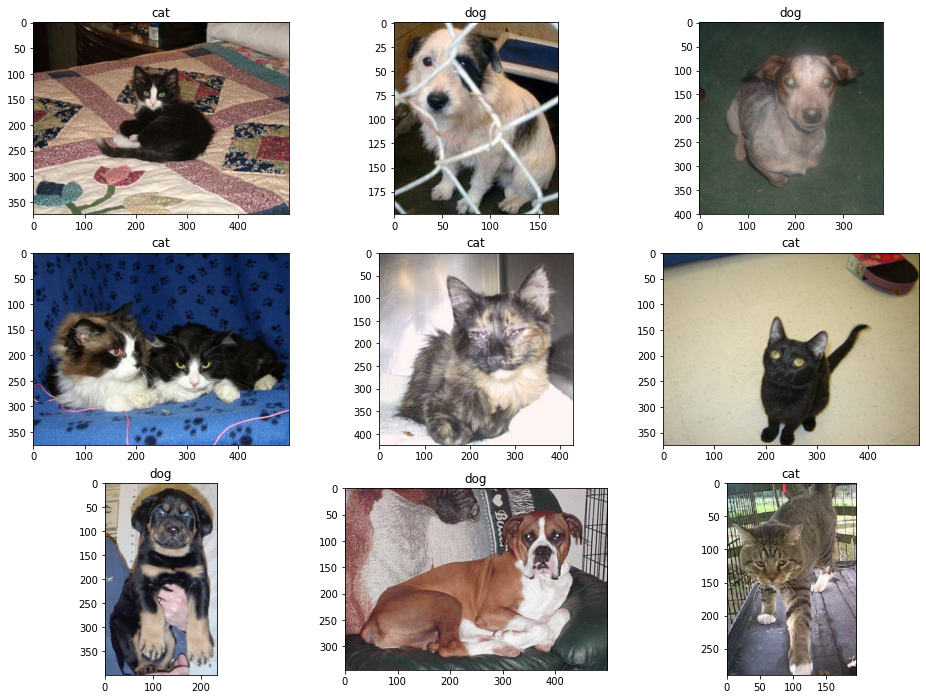

In [9]:
# printing few images 
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [10]:
# split train and validation subsets
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=16)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 19520
Validation Data: 4880
Test Data: 600


## Image augumentation (torch transforms)

In [11]:
# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

## Load cats-dogs dataset

In [12]:
# Define class to manage cats and dogs dataset 
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [13]:
# defining train, validation and test dataset
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [14]:
#loading dataloader
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

## The transformer encoder - Efficient attention
A ViT interprets an image as a sequence of patches and process it by a standard Transformer encoder as used in NLP. This simple, yet scalable, strategy works surprisingly well when coupled with pre-training on large datasets. Thus, Vision Transformer matches or exceeds the state of the art on many image classification datasets, whilst being relatively cheap to pre-train. (A. Dosovitskiy, 2021)

<img src="https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png" width="900px"/>

In [15]:
#Line transformer 
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [16]:
#Visual transformer
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [17]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [18]:
# enable training graphics widget
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Train model with batch trainning

In [19]:
#start training
loss_accuracy = []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    loss_accuracy.append([epoch_loss,epoch_accuracy])
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6956 - acc: 0.5060 - val_loss : 0.6909 - val_acc: 0.5355



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6911 - acc: 0.5239 - val_loss : 0.6905 - val_acc: 0.5288



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6847 - acc: 0.5520 - val_loss : 0.6807 - val_acc: 0.5700



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6793 - acc: 0.5679 - val_loss : 0.6781 - val_acc: 0.5720



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6723 - acc: 0.5798 - val_loss : 0.6735 - val_acc: 0.5810



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6690 - acc: 0.5883 - val_loss : 0.6646 - val_acc: 0.5998



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6646 - acc: 0.5854 - val_loss : 0.6465 - val_acc: 0.6179



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6543 - acc: 0.6001 - val_loss : 0.6433 - val_acc: 0.6183



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6483 - acc: 0.6099 - val_loss : 0.6359 - val_acc: 0.6390



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6408 - acc: 0.6214 - val_loss : 0.6391 - val_acc: 0.6177



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6442 - acc: 0.6187 - val_loss : 0.6301 - val_acc: 0.6309



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6294 - acc: 0.6382 - val_loss : 0.6181 - val_acc: 0.6567



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6235 - acc: 0.6434 - val_loss : 0.6201 - val_acc: 0.6455



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6175 - acc: 0.6475 - val_loss : 0.6143 - val_acc: 0.6520



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6134 - acc: 0.6523 - val_loss : 0.6034 - val_acc: 0.6725



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6063 - acc: 0.6632 - val_loss : 0.6013 - val_acc: 0.6644



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6031 - acc: 0.6633 - val_loss : 0.6109 - val_acc: 0.6540



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6022 - acc: 0.6650 - val_loss : 0.6057 - val_acc: 0.6597



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5952 - acc: 0.6736 - val_loss : 0.5980 - val_acc: 0.6648



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5946 - acc: 0.6772 - val_loss : 0.5905 - val_acc: 0.6725



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5891 - acc: 0.6817 - val_loss : 0.5865 - val_acc: 0.6767



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5857 - acc: 0.6847 - val_loss : 0.5903 - val_acc: 0.6788



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5855 - acc: 0.6833 - val_loss : 0.5767 - val_acc: 0.6883



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5828 - acc: 0.6923 - val_loss : 0.5846 - val_acc: 0.6772



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5785 - acc: 0.6905 - val_loss : 0.5762 - val_acc: 0.6907



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.5826 - acc: 0.6883 - val_loss : 0.5841 - val_acc: 0.6918



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5802 - acc: 0.6930 - val_loss : 0.5895 - val_acc: 0.6767



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5760 - acc: 0.6950 - val_loss : 0.5799 - val_acc: 0.6826



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5767 - acc: 0.6913 - val_loss : 0.5780 - val_acc: 0.6920



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5746 - acc: 0.6966 - val_loss : 0.5757 - val_acc: 0.6843



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5698 - acc: 0.6980 - val_loss : 0.5674 - val_acc: 0.6960



  0%|          | 0/305 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.5708 - acc: 0.7021 - val_loss : 0.5679 - val_acc: 0.6964



In [23]:
# save model in order to use it later
torch.save(model,"vit.weights")

In [45]:
# copy results to cpu
loss_acc = []
for la in loss_accuracy:
    #print(la.cpu().detach().numpy())
    loss_acc.append(np.array([la[0].cpu().detach(),la[1].cpu().detach()]))

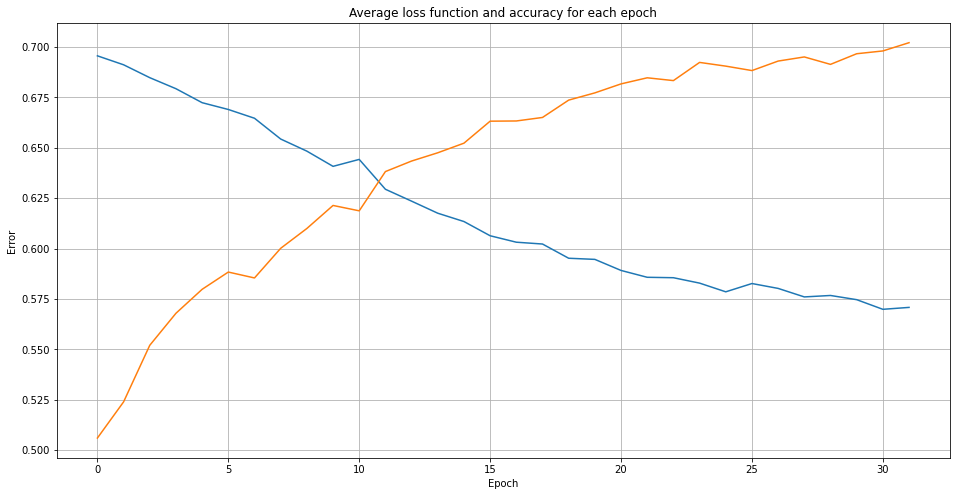

In [47]:
# plot loss function and accuracy along epochs
plt.figure(figsize=(16,8))
plt.plot(loss_acc)
plt.title("Average loss function and accuracy for each epoch")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.grid()

## Test model

In [48]:
# load model
model = torch.load('vit.weights')
# use model in cpu for validation (gpu for training)
model.to('cpu')

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

In [49]:
predictions = np.empty(0)
test_accuracy = 0
test_loss = 0
with torch.no_grad():
    # turn model on evaluation mode
    model.eval()
    for data, label in test_loader:
        #print(data)
        test_output = model(data)
        prediction = test_output.argmax(dim=1).cpu().detach().numpy()
        predictions = np.concatenate((predictions,prediction),axis=0)        
        #test_loss = criterion(val_output, label)
        acc = (test_output.argmax(dim=1) == label).float().mean()
        test_accuracy += acc
        #test_loss += test_loss
        
    test_accuracy = test_accuracy/len(test_loader)
    test_loss = test_loss/len(test_loader)

In [50]:
print("Accuracy on test set: ",test_accuracy.item())

Accuracy on test set:  0.7182291746139526


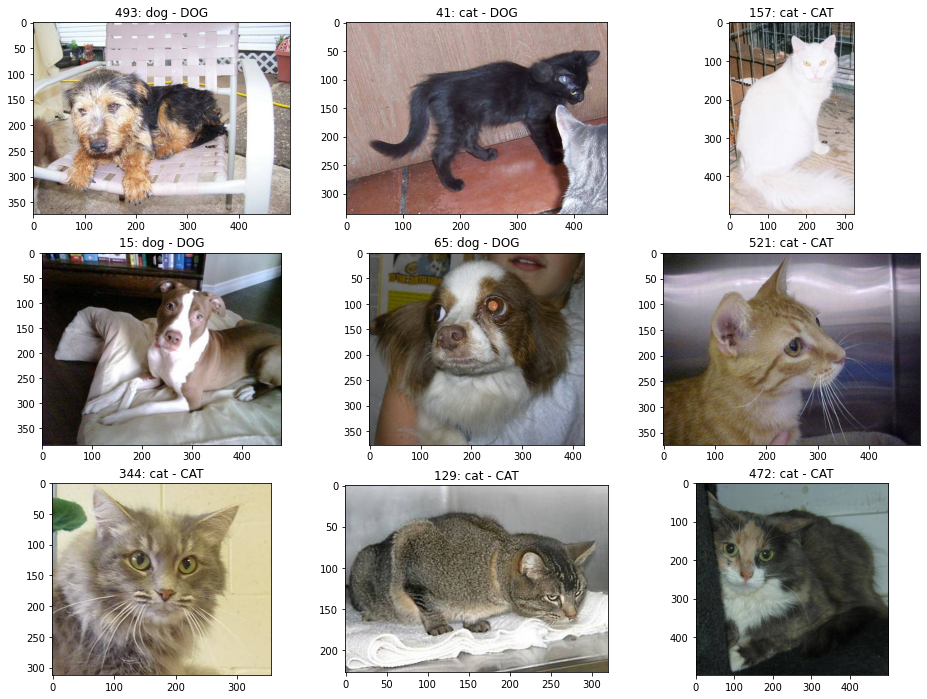

In [59]:
# printing few images 
labels_text = {0:'CAT',1:'DOG'}
random_idx = np.random.randint(1, len(test_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for i, ax in enumerate(axes.ravel()):
    idx = random_idx[i]
    img = Image.open(test_list[idx])
    label_predicted = labels_text[predictions[idx]]
    ax.set_title(f'{idx}: {test_labels[idx]} - {label_predicted}')
    ax.imshow(img)